# -Подключение к БД через Python-
#### (на примере PostgreSQL)


#### Я узнаю:
#### -как подключиться к СУБД с помощью библиотек Python для работы с SQL базами данных;
#### -как управлять базами данных PostgreSQL;
#### -как выполнять запросы к базе данных внутри приложения Python;
#### -как разрабатывать приложения для разных баз данных.

# 1.
### В этом уроке мы разработаем очень маленькую базу данных приложения для социальных сетей. База данных будет состоять из четырех таблиц:

### 1)users
### 2) posts
### 3) comments
### 4) likes

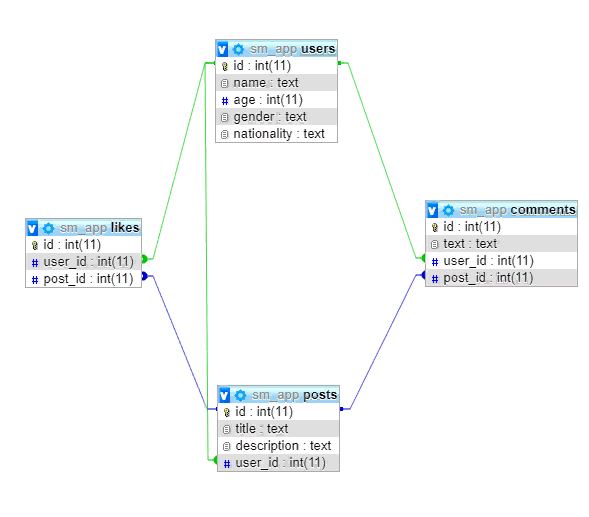

[Пользователи (users) и публикации (posts) будут иметь тип связи один-ко-многим: одному читателю может понравиться несколько постов. Точно так же один и тот же юзер может оставлять много комментариев (comments), а один пост может иметь несколько комментариев. Таким образом, и users, и posts по отношению к comments имеют тот же тип связи. А лайки (likes) в этом плане идентичны комментариям.]

In [1]:
pip install psycopg2

Note: you may need to restart the kernel to use updated packages.


# 2. Подключение к БД

In [3]:
import psycopg2

In [4]:
#Определим функцию create_connection() для подключения к базе данных PostgreSQL:
from psycopg2 import OperationalError 

def create_connection(db_name, db_user, db_password, db_host, db_port):
    connection = None
    try:                               #обработка исключений
        connection = psycopg2.connect(
            database=db_name,
            user=db_user,
            password=db_password,
            host=db_host,
            port=db_port,
        )
        print("Connection to PostgreSQL DB successful")
    except OperationalError as e:
        print(f"The error '{e}' occurred")
    return connection

In [5]:
connection = create_connection(
    "postgres", "postgres", "Y756v4", "127.0.0.1", "5432"      # подключаемся к БД с помощью нашей функции
                              )

Connection to PostgreSQL DB successful


In [6]:
# создание БД внутри дефолтной
def create_database(connection, query):
    connection.autocommit = True
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        print("Query executed successfully")
    except OperationalError as e:
        print(f"The error '{e}' occurred")

create_database_query = "CREATE DATABASE sm_app"
create_database(connection, create_database_query)

DuplicateDatabase: ОШИБКА:  база данных "sm_app" уже существует


In [8]:
# подключаемся к новой БД
connection = create_connection(
    "sm_app", "postgres", "Y756v4", "127.0.0.1", "5432"
)

Connection to PostgreSQL DB successful


# 3. Создание таблиц

Мы можем использовать функцию execute_query() для организации таблиц, вставки, изменения и удаления записей в вашей базе данных PostgreSQL.

In [9]:
def execute_query(connection, query):
    connection.autocommit = True
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        print("Query executed successfully")
    except OperationalError as e:
        print(f"The error '{e}' occurred")

Создадим внутри базы данных sm_app таблицу users:

In [10]:
#Создадим внутри базы данных sm_app таблицу users:
create_users_table = """
CREATE TABLE IF NOT EXISTS users (
  id SERIAL PRIMARY KEY,
  name TEXT NOT NULL, 
  age INTEGER,
  gender TEXT,
  nationality TEXT
)
"""

execute_query(connection, create_users_table)

Query executed successfully


In [13]:
#Создадим внутри базы данных sm_app таблицу posts:
create_posts_table = """
CREATE TABLE IF NOT EXISTS posts (
  id SERIAL PRIMARY KEY, 
  title TEXT NOT NULL, 
  description TEXT NOT NULL, 
  user_id INTEGER REFERENCES users(id)
)
"""

execute_query(connection, create_posts_table)

Query executed successfully


In [14]:
#Создадим внутри базы данных sm_app таблицу comments:
create_comments_table = """
CREATE TABLE IF NOT EXISTS comments (
  id SERIAL PRIMARY KEY, 
  text TEXT NOT NULL, 
  post_id INTEGER REFERENCES posts(id), 
  user_id INTEGER REFERENCES users(id)
)
"""
execute_query(connection, create_comments_table)

Query executed successfully


In [15]:
#Создадим внутри базы данных sm_app таблицу likes:
create_likes_table = """
CREATE TABLE IF NOT EXISTS likes (
  id SERIAL PRIMARY KEY, 
  post_id INTEGER REFERENCES posts(id), 
  user_id INTEGER REFERENCES users(id)
)
"""
execute_query(connection, create_likes_table)

Query executed successfully


# 4. Вставка записей в таблицы

В psycopg2 используется такой подход: мы передаем SQL-запрос с заполнителями и списком записей методу execute().
Каждая запись в списке должна являться кортежем, значения которого соответствуют значениям столбца в таблице БД.
Вот как мы можем вставить пользовательские записи в таблицу users:

Список users содержит пять пользовательских записей в виде кортежей.
Затем мы создаём строку с пятью элементами-заполнителями (%s), соответствующими пяти пользовательским записям.
Строка-заполнитель объединяется с запросом, который вставляет записи в таблицу users.
Наконец, строка запроса и пользовательские записи передаются в метод execute().

!Поскольку мы установили автоинкремент для столбца id, нам не нужно указывать его дополнительно.Таблица users будет автоматически заполнена пятью записями со значениями id от 1 до 5!

In [23]:
# вставили записи в таблицу users:
users = [
    ("James", 25, "male", "USA"),
    ("Leila", 32, "female", "France"),
    ("Brigitte", 35, "female", "England"),
    ("Mike", 40, "male", "Denmark"),
    ("Elizabeth", 21, "female", "Canada"),
]                                          # кортежи с записями таблицы

user_records = ", ".join(["%s"] * len(users))

insert_query = (
    f"INSERT INTO users (name, age, gender, nationality) VALUES {user_records}"
)

connection.autocommit = True
cursor = connection.cursor()
cursor.execute(insert_query, users)

In [21]:
# вставили записи в таблицу posts:
posts = [
    ("Happy", "I am feeling very happy today", 1),
    ("Hot Weather", "The weather is very hot today", 2),
    ("Help", "I need some help with my work", 2),
    ("Great News", "I am getting married", 1),
    ("Interesting Game", "It was a fantastic game of tennis", 5),
    ("Party", "Anyone up for a late-night party today?", 3),
]

post_records = ", ".join(["%s"] * len(posts))

insert_query = (
    f"INSERT INTO posts (title, description, user_id) VALUES {post_records}"
)

connection.autocommit = True
cursor = connection.cursor()
cursor.execute(insert_query, posts)

In [24]:
# вставили записи в таблицу comments:
comments = [
  ('Count me in', 1, 6),
  ('What sort of help?', 5, 3),
  ('Congrats buddy', 2, 4),
  ('I was rooting for Nadal though', 4, 5),
  ('Help with your thesis?', 2, 3),
  ('Many congratulations', 5, 4),
]

comments_records = ", ".join(["%s"] * len(comments))

insert_query = (
    f"INSERT INTO comments (text, user_id, post_id) VALUES {comments_records}"
)

connection.autocommit = True
cursor = connection.cursor()
cursor.execute(insert_query, comments)


In [25]:
# вставили записи в таблицу likes:
likes = [
  (1, 6),
  (2, 3),
  (1, 5),
  (5, 4),
  (2, 4),
  (4, 2),
  (3, 6),
]

likes_records = ", ".join(["%s"] * len(likes))

insert_query = (
    f"INSERT INTO likes (user_id, post_id) VALUES {likes_records}"
)

connection.autocommit = True
cursor = connection.cursor()
cursor.execute(insert_query, likes)

# 5. Извлечение данных из записей

Процесс выбора записей из таблицы PostgreSQL с помощью модуля psycopg2. Снова используем cursor.execute(), затем метод fetchall()для выбора записей из таблицы. Следующий скрипт выбирает все записи из таблицы users:

In [62]:
def execute_read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except OperationalError as e:
        print(f"The error '{e}' occurred")

select_users = "SELECT * FROM users WHERE age = 21"
users = execute_read_query(connection, select_users)

for user in users:
    print(user)

(5, 'Elizabeth', 21, 'female', 'Canada')
(10, 'Elizabeth', 21, 'female', 'Canada')
(15, 'Elizabeth', 21, 'female', 'Canada')


# 6. Обновление записей таблицы

In [45]:
select_post_description = "SELECT description FROM posts WHERE id = 3"

post_description = execute_read_query(connection, select_post_description)

for description in post_description:
    print(description)

('I need some help with my work',)


In [50]:
                            # Проблема в том, что у PostgreSQL в двойные кавычки заключаются названия БД, таблиц и столбцов.
                            # А строковые значения надо вставлять в одинарных кавычках!
update_post_description = """
UPDATE
  posts
SET
  description = 'I do not need some help with my work'
WHERE
  id = 3
"""

execute_query(connection, update_post_description)

Query executed successfully


## 7. Удаление записей таблицы

In [57]:
delete_comment = "DELETE FROM comments WHERE id = 5"
execute_query(connection, delete_comment)
# удалила 5-й комментарий и 

Query executed successfully


In [56]:
select_comments = "SELECT * FROM comments"
comments = execute_read_query(connection, select_comments)

for comment in comments:
    print(comment)
# показала таблицу после этого

(1, 'Count me in', 6, 1)
(2, 'What sort of help?', 3, 5)
(3, 'Congrats buddy', 4, 2)
(4, 'I was rooting for Nadal though', 5, 4)
(6, 'Many congratulations', 4, 5)
